In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
from datetime import timedelta, datetime, date
from matplotlib.pyplot import figure
from sklearn.metrics import precision_recall_fscore_support
from empiricaldist import Cdf

In [2]:
query = '''
    
    SELECT * FROM `bem---beli-emas-murni.dataset_dev.nth_hva_users_metrics`

    '''

project_id = 'bem---beli-emas-murni'
bqclient = bigquery.Client(project = project_id)
df = bqclient.query(query).to_dataframe()
df = df[df['install_month'] >= date(2021, 10, 1) ]
df.rename(columns={"type": "usergroup"}, inplace=True)

In [3]:
df.columns

Index(['user_id', 'install_day', 'usergroup', 'first_tx', 'D7_no_topups',
       'D14_no_topups', 'D7_net_flow_amount', 'D14_net_flow_amount',
       'D7_number_of_trades', 'D14_number_of_trades', 'D7_engagement_time',
       'D14_engagement_time', 'D7_unique_sessions', 'D14_unique_sessions',
       'D7_days_app_open', 'D14_days_app_open', 'D7_buy_clicked_count',
       'D14_buy_clicked_count', 'reg_date', 'kyc_date', 'install_month',
       'install_to_trx_day', 'reg_to_kyc_day', 'install_to_reg_day'],
      dtype='object')

In [4]:
def multicol_cdfvis(df, colnames):
    for colname in colnames:  #["D7_no_topups", "D14_no_topups", "D7_number_of_trades", "D14_number_of_trades"]:
        fig = plt.figure(figsize=(15,3)).suptitle(colname,fontsize=15)
        for name, group in df.groupby('usergroup'):
            subdf = Cdf.from_seq(group[colname])
            subdf.plot()
            if name == 'Others':
                hh = subdf.quantile(0.995)
        plt.xlim([0, hh])
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.legend(df.groupby('usergroup').groups.keys())
        plt.show()   

In [8]:
def threshold_search(df, colname):
    df_sub = df[["usergroup", colname]].copy()
    df_sub.usergroup = df_sub.usergroup.replace({'HVA':1, 'Others':0})
    df_negative = df_sub.loc[df_sub.usergroup==0]
    subdf = Cdf.from_seq(df_negative[colname])
    hh = int(subdf.quantile(0.995))
    if hh > 100:
        stepsize = 10
    else:
        stepsize =1
    all_results = []
    for threshold in range(0, hh, stepsize):
        df_sub.loc[:, "predicted_label"] = 0
        df_sub.loc[df_sub[colname]>threshold, "predicted_label"] = 1
        p, r, f, _ = precision_recall_fscore_support(df_sub.usergroup, df_sub.predicted_label)
        all_results.append([threshold, p[1], r[1], f[1]])
    srt = sorted(all_results,key=lambda x: x[-1], reverse=True)
    print(colname + " threshold is {}".format(srt[0][0]))
    print("precision: %.3f, recall: %.3f, f1score: %.3f" %(srt[0][1], srt[0][2], srt[0][3]))

### A.  User Attributes related to Deep Actions

1. Top-up 

2. Number of Trades

##### CDF Plots

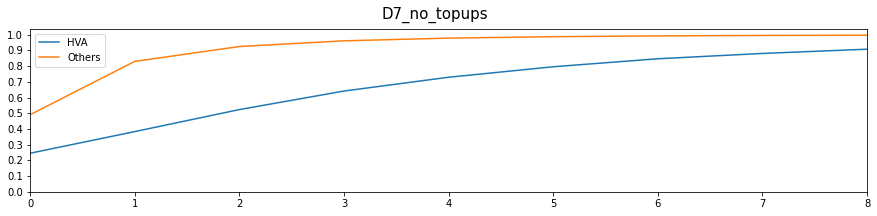

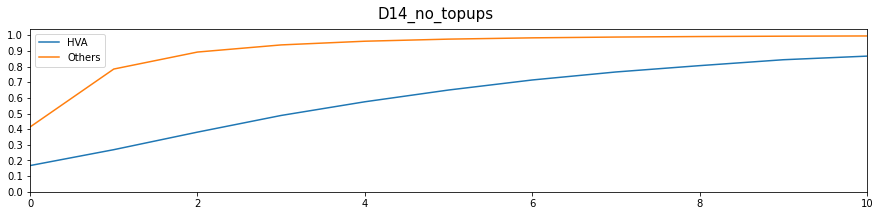

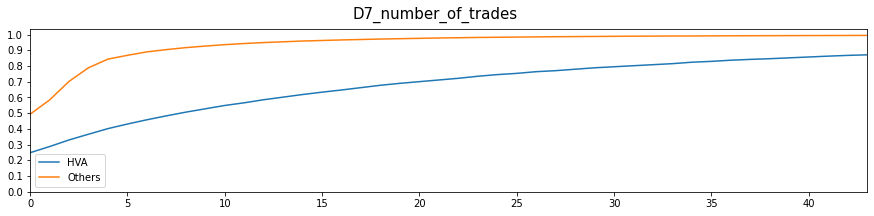

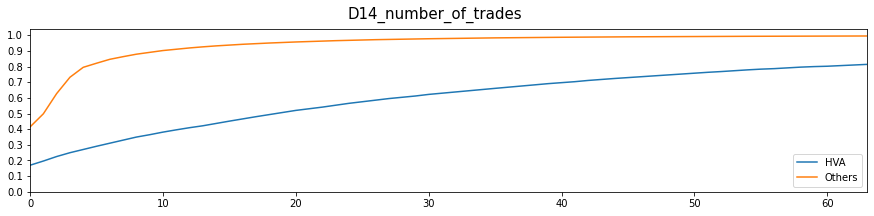

In [6]:
colnames = ["D7_no_topups", "D14_no_topups", "D7_number_of_trades", "D14_number_of_trades"]
multicol_cdfvis(df, colnames)

##### Find optimal threshold for each indicator to classify HVA and Others

For example, if we set the rule as if the users top up more than 4 times in their first 7 day transaction, they will be our high value users. The precision could be 25.8%. 

In the framework, we iterate different thresholds for each indicator to achieve the highest F1 score which consider precision and recall together. 

In [9]:
for colname in colnames:
    threshold_search(df, colname)

D7_no_topups threshold is 4
precision: 0.259, recall: 0.271, f1score: 0.265
D14_no_topups threshold is 5
precision: 0.285, recall: 0.350, f1score: 0.314
D7_number_of_trades threshold is 22
precision: 0.288, recall: 0.278, f1score: 0.283
D14_number_of_trades threshold is 34
precision: 0.355, recall: 0.346, f1score: 0.351


### B. User Attributes related to shallow actions
1. Days of app open

2. Unique of Session

3. Engagement Time

##### CDF Plots & Optimal Threshold

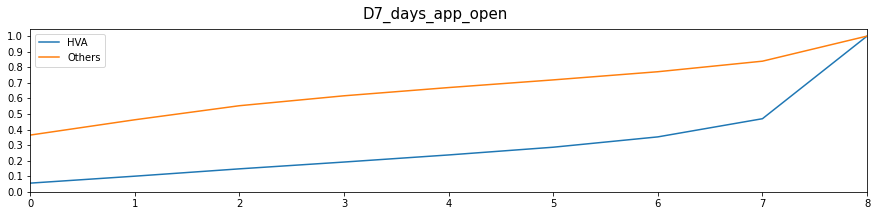

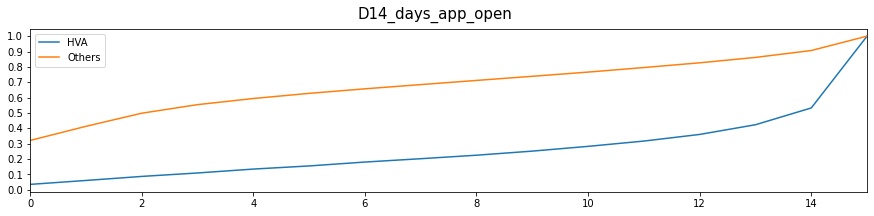

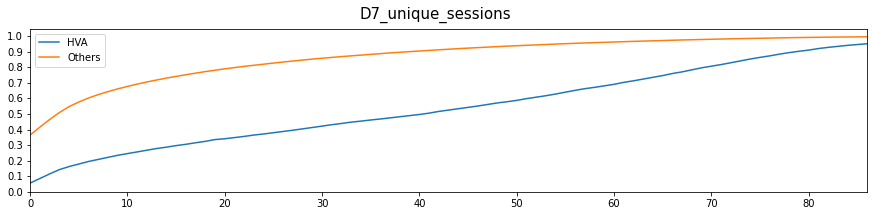

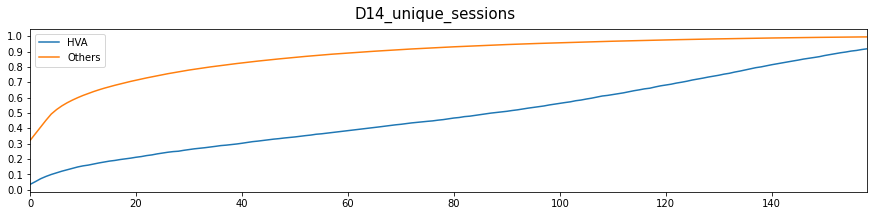

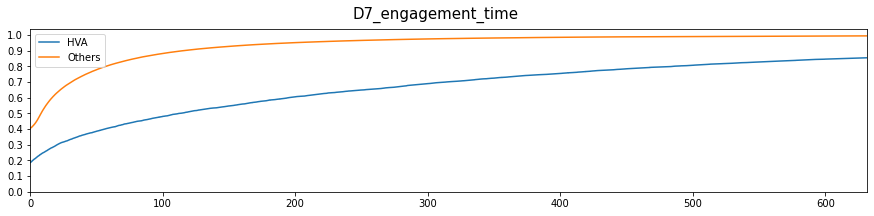

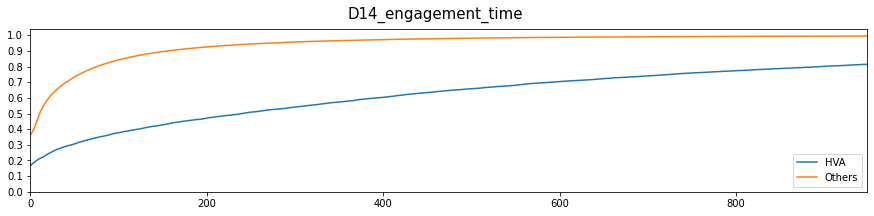

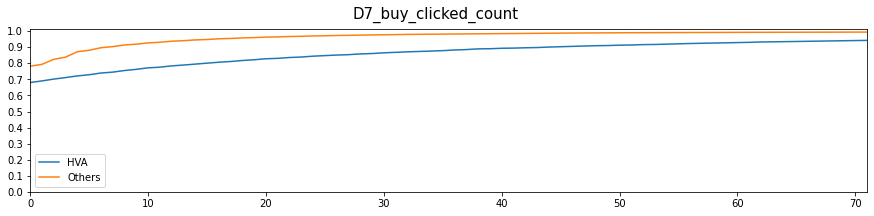

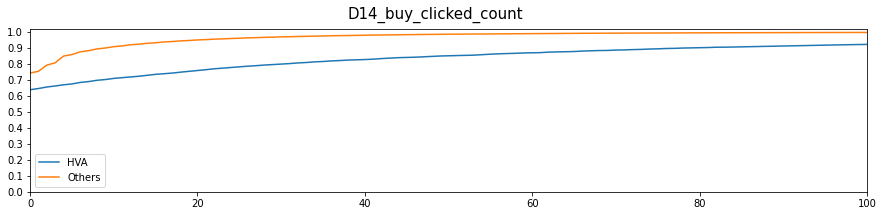

In [10]:
colnames = ["D7_days_app_open", "D14_days_app_open", "D7_unique_sessions", "D14_unique_sessions", "D7_engagement_time", "D14_engagement_time", "D7_buy_clicked_count", "D14_buy_clicked_count"]
multicol_cdfvis(df, colnames)

In [11]:
for colname in colnames:
    threshold_search(df, colname)

D7_days_app_open threshold is 7
precision: 0.085, recall: 0.531, f1score: 0.147
D14_days_app_open threshold is 14
precision: 0.124, recall: 0.467, f1score: 0.196
D7_unique_sessions threshold is 60
precision: 0.189, recall: 0.310, f1score: 0.235
D14_unique_sessions threshold is 110
precision: 0.245, recall: 0.380, f1score: 0.298
D7_engagement_time threshold is 330
precision: 0.284, recall: 0.289, f1score: 0.287
D14_engagement_time threshold is 510
precision: 0.347, recall: 0.337, f1score: 0.342
D7_buy_clicked_count threshold is 26
precision: 0.138, recall: 0.148, f1score: 0.143
D14_buy_clicked_count threshold is 40
precision: 0.182, recall: 0.174, f1score: 0.178


### C. User Attributes related to Conversion Rate

1. Install to Trx Day

2. Install to Reg Day

##### CDF Plots

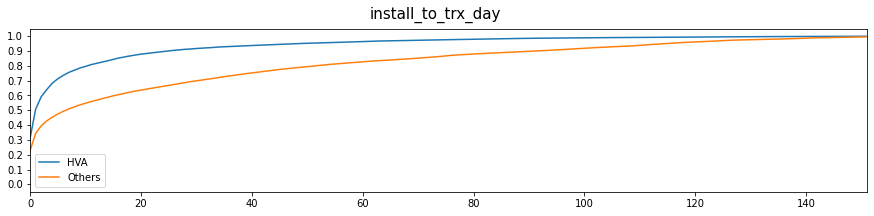

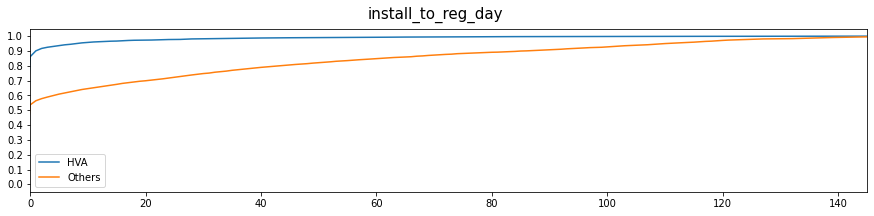

In [14]:
colnames =["install_to_trx_day","install_to_reg_day"]
multicol_cdfvis(df, colnames)

### D. Rule Set:

For D7: D7_no_topups > 4 and D7_engagement_time>330 and D7_number_of_trades>22

For D14: D14_no_topups > 5 and D14_engagement_time>510 and D14_number_of_trades>34

In [12]:
def threshold_search_14(df):
       df.usergroup = df.usergroup.replace({'HVA':1, 'Others':0})
       df.loc[:, "predicted_label"] = 0
       df.loc[((df['D14_no_topups']>5) & 
           (df['D14_engagement_time']>510) & 
           (df['D14_number_of_trades']>34)) | 
           (df['D7_net_flow_amount']> 5000000)
           , "predicted_label"] = 1
       p, r, f, _ = precision_recall_fscore_support(df.usergroup, df.predicted_label)
       print("precision: %.3f, recall: %.3f, f1score: %.3f" %(p[1], r[1], f[1]))
def threshold_search_7(df):
       df.usergroup = df.usergroup.replace({'HVA':1, 'Others':0})
       df.loc[:, "predicted_label"] = 0
       df.loc[((df['D7_no_topups']>4) & 
           (df['D7_engagement_time']>330) & 
           (df['D7_number_of_trades']>22)) |
           (df['D7_net_flow_amount']> 5000000), "predicted_label"] = 1
       p, r, f, _ = precision_recall_fscore_support(df.usergroup, df.predicted_label)
       print("precision: %.3f, recall: %.3f, f1score: %.3f" %(p[1], r[1], f[1]))

In [13]:
threshold_search_14(df)
threshold_search_7(df)

precision: 0.627, recall: 0.378, f1score: 0.472
precision: 0.604, recall: 0.344, f1score: 0.438
